### Task 1.1

#### Unzip train data

In [100]:
# import tarfile
# from pathlib import Path
# from tqdm import tqdm

# def expand_tar(tar_gz_file, destination_folder):

#     # Define the destination directory for extraction
#     # destination_folder = str(tar_gz_file.parent)

#     try:
#         # Open the .tar.gz file in read mode ('r:gz' for gzipped tar archives)
#         with tarfile.open(tar_gz_file, 'r:gz') as tar:
#             # Extract all contents to the specified destination folder
#             tar.extractall(destination_folder)
#         print(f"Successfully extracted '{tar_gz_file}' to '{destination_folder}'")
#     except tarfile.ReadError as e:
#         print(f"Error reading tar.gz file: {e}")
#     except FileNotFoundError:
#         print(f"Error: The file '{tar_gz_file}' was not found.")
#     except Exception as e:
#         print(f"An unexpected error occurred: {e}")
#     return


# test_files=list(sorted(Path("../data/MOVi-MC-AC/train").glob("*.tar.gz")))
# completed = []

# print("completed", completed)
# for file in tqdm(test_files):
#     if file not in completed:
#         try:
#             expand_tar(file, destination_folder='../data/MOVi-MC-AC/unzipped_data')
#             completed.append(file)
#         except Exception as e:
#             print(f"Error in unzipping {str(file)}: {e}")
#     else:
#         continue

#### Import Dataloader

In [101]:
#!/usr/bin/env python3

# From the provided material
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
import torch
from PIL import Image
import numpy as np
import random

# Define some check variables
N_SAMPLES_DOWNLOADED_TRAIN = 170
N_SAMPLES_DOWNLOADED_TEST = 39
N_TOT_FRAMES = 24

# This is function from Amar-S
class MOVi_Dataset(Dataset):
    def __init__(self, 
                 root,
                 split = 'train' or 'test', 
                 n_frames = 8,
                 n_samples = 1000,
                 #box_format = 'xywh'
                 ):
        """
        Initialize the MOVi dataset loader.
        
        Args:
            root: The root folder that holds the unzipped sample folders
            split: Which root subfolder to draw from (train or test)
            n_frames: How many consecutive frames to load
            n_samples: How many samples to load
        """
        print('Dataset init on', split)

        self.split = split
        # self.top_dir = f'{root}/{split}'
        self.top_dir = f'{root}'
        print('Init data top dir:', self.top_dir)

        #self.box_format = box_format

        # Get directories in data_dir/train-test
        self.scenes = [entry for entry in os.listdir(self.top_dir) if os.path.isdir(os.path.join(self.top_dir, entry))]
        
        # assert n_frames <= N_TOT_FRAMES
        self.n_frames = n_frames
        # assert n_samples <= N_SAMPLES_DOWNLOADED_TRAIN
        self.n_samples = n_samples

    def __len__(self):
        # In theory this could be like n_scenes*n_objects
        # To get total number of (cam-invariant) objects
        return self.n_samples

    def load_cam_frames(self, scene, 
                    cam_idx,
                    start, stop, 
                    modality):
        """
        One load-frames loads camera-level stuff (rgb, depth)
        The other one loads object-level stuff (scene/cam/obj_i/amodal_mask or content)
        """
        # Load frame range
        imgs = []
        suffix = '.png'

        totensor = ToTensor()

        for i in range(start, stop):
            # loads train/scene_id/cam_id/frames_or_depth_or_modal/frame_id.png
            if modality == 'modal_masks':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/segmentation_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file))
            
            if modality == 'rgba_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/rgba_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file).convert('RGB')) # RGB, 3 chans

            if modality == 'depth_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/depth_{str(i).zfill(5)}.tiff'
                tens = totensor(Image.open(load_file).convert('RGB')) # RGB, 3 chans
                
            tens = totensor(Image.open(load_file))
            imgs.append(tens)

        tensor = torch.stack(imgs, dim = 1)

        return tensor
    
    def load_obj_frames(self, scene, 
                    cam_idx,
                    object_idx,
                    start, stop, 
                    modality):
        """
        This loaded loads object-level stuff
        """
        # Load frame range
        imgs = []
        # amodal_segs, content, rgba_full, modal_masks, depth_full
        suffix = '.png'

        totensor = ToTensor()

        for i in range(start, stop):
            if modality == 'amodal_segs':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/segmentation_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file))

            if modality == 'content':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/rgba_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file).convert('RGB'))
                
            if modality == 'depth_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/rgba_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file).convert('RGB'))
            imgs.append(tens)

        tensor = torch.stack(imgs, dim = 1)
        return tensor


    def __getitem__(self, idx):
        # Select a random sample
        random_scene = np.random.choice(self.scenes)

        # Get the list of objects in that sample
        all_object_ids = self.all_objects(self.top_dir + random_scene + '/camera_0000/' )
        
        # Pick a random object 
        target_object_id = np.random.choice(all_object_ids)

        """
        Loading from multiple cameras in parallel:
        """

        # Make these random
        start = random.randint(0, 24-self.n_frames) # pick random integer between 0 and 24-n_frames 
        stop = start+self.n_frames # end at 

        i = random.randint(0, 5) # pick a random camera
        frames, depths, modal_masks, amodal_segs, amodal_content = self.load_camera(random_scene, cam_id = f'camera_{str(i).zfill(4)}', 
                                                                                    obj_id = target_object_id, start = start, stop = stop)
        
        # Inflate modal masks to 255
        modal_masks = modal_masks*255
        modal_masks = modal_masks.to(torch.uint8)
        sample = {
            'frames': frames,
            'depths': depths,
            'modal_masks': modal_masks,
            'amodal_masks': amodal_segs,
            'amodal_content': amodal_content,
        }
        return sample

    
    def load_camera(self, scene_id, cam_id, obj_id, start, stop):

        # Load the target objects 
        modal_segs = self.load_cam_frames(scene_id, 
                                            cam_id,
                                            start, stop,
                                            'modal_masks')

        modal_segs = modal_segs*255
        modal_segs = modal_segs.int()

        # Load frames corresponding to inputs
        frames = self.load_cam_frames(scene_id, 
                                      cam_id, 
                                      start, 
                                      stop, 
                                      'rgba_full')[:-1] #drop the A 

        # Load depth (though we will have to replace with Depth-Anything-V2 estimates)
        depths = self.load_cam_frames(scene_id, cam_id, start, stop, 'depth_full')

        amodal_segs = self.load_obj_frames(scene_id, cam_id, obj_id, start, stop, 'amodal_segs')
        amodal_content = self.load_obj_frames(scene_id, cam_id, obj_id, start, stop, 'content')
        
        return frames, depths, modal_segs, amodal_segs, amodal_content
    
    def all_objects(self, pth):
        """
        Given a path, get the objects at that path using regex
        """
        #print('looking for all objects at', pth)
        
        # Find all matches
        matches = []
        for fname in sorted(os.listdir(pth)):
            if 'obj_' in fname:
                matches.append(fname)

        #print(matches)
        return matches # list of ['obj_0001', 'obj_0009',...]
    

# Making minimal changes
# Inherit from the MOViDataset class
# pass the movi dataset (collection of many frames)
# and blow it up into a Dataset which has the tensor for each frame
# This is a dataloader ready for task 1.1
class MOVi_ImageDataset(MOVi_Dataset):
    """
    Loads the MOVi dataset from file, casting it in a form ready for Image Models.
    One frame per sample.
    Inherits from the MOVi_Dataset class - so requires the same args.
    Example usage:
    image_ds = MOVi_ImageDataset(root=ROOT_PATH, split = 'test', n_frames = 8, n_samples=30)
    """
    def __init__(self, n_cameras=6,nframe_sample=24,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self.frame_indices = []
        # Build a list of (scene, camera, object, frame_idx) for all frames
        for scene in self.scenes:
            for cam_id in [f'camera_{str(i).zfill(4)}' for i in range(n_cameras)]:  # assuming 6 cameras
                obj_path = os.path.join(self.top_dir, scene, cam_id)
                if not os.path.exists(obj_path):
                    continue
                object_ids = self.all_objects(obj_path)
                for obj_id in object_ids:
                    # Assume all videos have 24 frames (0..24)
                    for frame_idx in range(nframe_sample):  # or use dynamic length if needed
                        self.frame_indices.append((scene, cam_id, obj_id, frame_idx))
    
    def __len__(self):
        return len(self.frame_indices)
    
    def __getitem__(self, idx):
        scene, cam_id, obj_id, frame_idx = self.frame_indices[idx]
        # Load a single frame for each modality
        frame = self.load_cam_frames(scene, cam_id, frame_idx, frame_idx+1, 'rgba_full').squeeze(1)[:-1] # ensure we get RGB 
        depth = self.load_cam_frames(scene, cam_id, frame_idx, frame_idx+1, 'depth_full').squeeze(1)
        modal_mask = self.load_cam_frames(scene, cam_id, frame_idx, frame_idx+1, 'modal_masks').squeeze(1)
        amodal_mask = self.load_obj_frames(scene, cam_id, obj_id, frame_idx, frame_idx+1, 'amodal_segs').squeeze(1)
        amodal_content = self.load_obj_frames(scene, cam_id, obj_id, frame_idx, frame_idx+1, 'content').squeeze(1)
        
        modal_mask = (modal_mask * 255).to(torch.uint8)
        
        sample = {
            'frame': frame,
            'depth': depth,
            'modal_mask': modal_mask,
            'amodal_mask': amodal_mask,
            'amodal_content': amodal_content,
            'scene': scene,
            'cam_id': cam_id,
            'obj_id': obj_id,
            'frame_idx': frame_idx
        }
        return sample

---

#### Existing utils

In [102]:
# PyTorch, Torchvision
import torch
from torch import nn
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.utils import make_grid
from torchvision.io import write_video

# Common
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from IPython.display import Video

# Utils from Torchvision
tensor_to_image = ToPILImage()
image_to_tensor = ToTensor()

In [103]:
def get_img_dict(img_dir):
    img_files = [x for x in img_dir.iterdir() if x.name.endswith('.png') or x.name.endswith('.tiff')]
    img_files.sort()

    img_dict = {}
    for img_file in img_files:
        img_type = img_file.name.split('_')[0]
        if img_type not in img_dict:
            img_dict[img_type] = []
        img_dict[img_type].append(img_file)
    return img_dict

In [104]:
def get_sample_dict(sample_dir):

    camera_dirs = [x for x in sample_dir.iterdir() if 'camera' in x.name]
    camera_dirs.sort()

    sample_dict = {}

    for cam_dir in camera_dirs:
        cam_dict = {}
        cam_dict['scene'] = get_img_dict(cam_dir)

        obj_dirs = [x for x in cam_dir.iterdir() if 'obj_' in x.name]
        obj_dirs.sort()

        for obj_dir in obj_dirs:
            cam_dict[obj_dir.name] = get_img_dict(obj_dir)

        sample_dict[cam_dir.name] = cam_dict

    return sample_dict

In [105]:
def make_obj_viz(cam_dict, cam_num=0):

    n_frames = 24
    n_cols = 6

    all_obj_ids = [x for x in sample_dict['camera_0000'].keys() if 'obj_' in x]
    obj_id_str = random.sample(all_obj_ids, k=1)[0]
    obj_id_int = int(obj_id_str.split('_')[1])

    grid_tensors = []
    for i in range(n_frames):
        grid = []
        scene_rgb_tensor = image_to_tensor(Image.open(cam_dict['scene']['rgba'][i]).convert('RGB'))
        grid.append(scene_rgb_tensor)
        scene_masks_tensor = image_to_tensor(Image.open(cam_dict['scene']['segmentation'][i]).convert('RGB'))
        grid.append(scene_masks_tensor)

        scene_masks_p = Image.open(cam_dict['scene']['segmentation'][i])
        scene_masks_p_tensor = torch.tensor(np.array(scene_masks_p))
        obj_modal_tensor = (scene_masks_p_tensor==obj_id_int)
        blended_obj_modal_tensor = scene_masks_tensor*obj_modal_tensor
        grid.append(blended_obj_modal_tensor)

        obj_amodal_tensor = image_to_tensor(Image.open(cam_dict[obj_id_str]['segmentation'][i]).convert('RGB'))
        blended_obj_amodal_tensor = blended_obj_modal_tensor + (obj_amodal_tensor != obj_modal_tensor)
        grid.append(blended_obj_amodal_tensor)

        obj_rgb_tensor = image_to_tensor(Image.open(cam_dict[obj_id_str]['rgba'][i]).convert('RGB'))
        grid.append(obj_rgb_tensor)

        blended_scene_obj_tensor = (scene_rgb_tensor/3 + 2*blended_obj_amodal_tensor/3)
        grid.append(blended_scene_obj_tensor)

        grid_tensors.append(make_grid(grid, nrow=n_cols, padding=2, pad_value=127))

    return grid_tensors

In [106]:
def make_vid(grid_tensors, save_path):
    vid_tensor = torch.stack(grid_tensors, dim=1).permute(1, 2, 3, 0)
    vid_tensor = (vid_tensor*255).long()
    write_video(save_path, vid_tensor, fps=5, options={'crf':'20'})

---
#### Train test split

In [107]:
def make_dataset11(videos_dir: str, 
                          inds: list[int] or None = None, 
                          random_seed: int = 42) -> tuple[torch.tensor, torch.tensor, list[dict]]: 
    """ 
    Loads one frame for every object viewed from every camera angle in every video in videos_dir and 
    returns the modal masks and amodal masks in tensor form.

    Parameters:
        - videos_dir: a directory where each sub-directory contains a video from Movi-MC-AC
        - inds: a list of the same length as the number of videos telling which frame of each video to load into the dataset
        - random_seed: an integer to set the random seed. Only necessary if inds is None.

    Returns: 
        - a tensor of modal masks
        - a tensor of amodal masks
        - a list of ALL images from ALL videos. TODO: abstract this into a separate function
        - TODO: also return a tensor of RGB images
    """

    # Save the RNG state to restore it after we're done
    prev_state = random.getstate()
    random.seed(random_seed)

    # If user does not specify, take one random frame from each video
    if inds is None: 
        inds = [random.randint(0, num_frames - 1) for i in range(num_vids)]
    random.setstate(prev_state)

    # Load a dictionary storing each video file
    videos_dir = Path(videos_dir)
    video_dicts = [get_sample_dict(Path(sample_dir)) for sample_dir in videos_dir.iterdir()]

    num_vids = len(video_dicts)

    # Count number of objects in each video
    num_obj_list = [None] * num_vids 
    for i in range(num_vids):
        num_obj_list[i] = sum([s.startswith('obj') for s in video_dicts[i]['camera_0000'].keys()])

    num_obj = sum(num_obj_list)
    
    # Every video in Movi-MC-AC has 24 frames and 6 camera angles
    num_cams = 6 
    num_frames = 24 

    # Sample size
    dataset_len = num_vids * num_cams * num_obj
    
    
    rgb_tensor = torch.empty((dataset_len, 3, 256, 256))
    modal_tensor = torch.empty((dataset_len, 256, 256))
    amodal_tensor = torch.empty((dataset_len, 256, 256))
    

    l = 0 # iterates through l = 0, ..., dataset_len - 1
    for i in range(num_vids): # for each video
        video_dict = video_dicts[i]
        cur_num_obj = num_obj_list[i]
        for j in range(num_cams): # for each camera angle
            cam_dict = video_dict[f'camera_{j:04d}']
            modal_masks = Image.open(cam_dict['scene']['segmentation'][inds[i]]) # load the modal masks
            rgb_image = Image.open(cam_dict['scene']['rgba'][inds[i]]).convert('RGB')
            rgb_mask = image_to_tensor(rgb_image)


            for k in range(cur_num_obj): # for each object
                amodal_mask = Image.open(cam_dict[f'obj_{k+1:04d}']['segmentation'][inds[i]]) # load the amodal mask
                
                modal_mask = (torch.tensor(np.array(modal_masks)) == (k + 1)).float() # extract the modal mask of a single object
                amodal_mask = image_to_tensor(amodal_mask)

                modal_tensor[l,:,:] = modal_mask 
                amodal_tensor[l,:,:] = amodal_mask
                rgb_tensor[l,:,:,:] = rgb_mask
                l += 1
    
    return rgb_tensor, modal_tensor, amodal_tensor, video_dicts


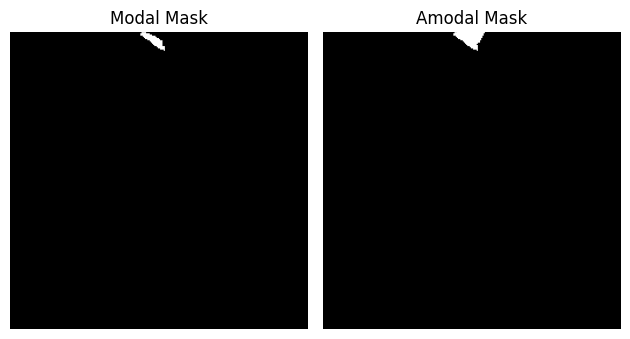

In [108]:
# Can put the sample data from the demo (the folder starting with ff...) in a 
# directory called `data` to test this
DIR_DATA = '../data/MOVi-MC-AC/sample_data'
rgb_tensor, modal_tensor, amodal_tensor, video_dicts = make_dataset11(DIR_DATA, 
                                                          [1]) # take the first frame of the video

# Display one set of modal & amodal masks
# Create a figure with 2 columns
fig, axes = plt.subplots(1, 2)

# Plot the images
axes[0].imshow(tensor_to_image(modal_tensor[8]), cmap='gray')  # First image
axes[0].set_title("Modal Mask")
axes[0].axis('off')  # Turn off axes

axes[1].imshow(tensor_to_image(amodal_tensor[8]), cmap='gray')  # Second image
axes[1].set_title("Amodal Mask")
axes[1].axis('off')  # Turn off axes

# Adjust layout
plt.tight_layout()
plt.show()

In [109]:
from math import floor
def train_val_test_split(X: torch.tensor, 
                         Y: torch.tensor, 
                         props: tuple[float, float, float], 
                         random_seed: int = 42) -> list[torch.tensor]:
    ''' 
    Split two tensors, X and Y, into train, validation, and test datasets according to proportions `probs`.

    Parameters:
        - X: input data
        - Y: output data
        - props: a length 3 tuple which must sum to 1. probs = (0.7, 0.2, 0.1) specifies 70% of the data 
        in training, 20% of the data in validation, and 10% in testing. Any of these three percentages can 
        be 0.
        - random_seed: Integer to set the RNG state.
    
    Return:
        - 6 tensors: X and Y split into train, validation, and test.

    Details:
    
    Validation data should be used for hyperparameter tuning and model selection, while test data should 
    be used for model evaluation (to make sure the model isn't under or overfitting).
    '''
    # Make sure proportions sum to 1, within floating point error
    if (abs(sum(props) - 1)) >= 1e-4: 
        raise ValueError("props must sum to 1")

    if X.shape[0] != Y.shape[0]: 
        raise ValueError("X and Y must have the same sample size.")
    
    n = X.shape[0]

    test_size = floor(n * props[2])

    # Make sure test size is not accidentally rounded to 0
    if props[2] > 1e-4:
        test_size = max(test_size, 1)

    # Make sure validation size is not accidentally rounded to 0
    val_size = floor(n * props[1])
    if props[1] > 1e-4:
        val_size = max(val_size, 1)

    data_inds = range(n)

    prev_state = random.getstate()
    random.seed(random_seed)

    test_inds = random.sample(data_inds, test_size)
    X_test = X[test_inds]
    Y_test = Y[test_inds]

    train_val_inds = set(data_inds) - set(test_inds)
    val_inds = random.sample(list(train_val_inds), val_size)
    X_val = X[val_inds]
    Y_val = Y[val_inds]

    train_inds = list(train_val_inds - set(val_inds))
    random.shuffle(train_inds)

    random.setstate(prev_state)

    X_train = X[train_inds]
    Y_train = Y[train_inds]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [110]:
# Example of splitting empty tensors
res = train_val_test_split(torch.empty((1001, 200, 200)), 
                           torch.empty((1001, 200, 200)), 
                           (0.7, 0.2, 0.1))
res

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

### Task 1.1

### Model

In [111]:
class Task_1_1_Dataset(Dataset):
    def __init__(self, rgb_tensor, modal_tensor, amodal_tensor):
        self.rgb_tensor = rgb_tensor
        self.modal_tensor = modal_tensor
        self.amodal_tensor = amodal_tensor

    def __len__(self):
        return self.rgb_tensor.shape[0]
    
    def __getitem__(self, index):
        return self.rgb_tensor[index], self.modal_tensor[index], self.amodal_tensor[index]

In [112]:
class Task_1_1_Model(nn.Module):

    def __init__(self):
        super(Task_1_1_Model, self).__init__()
        # Define multiple Conv2D layers with 'same' padding
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)

        x = self.decoder(x)

        return x

In [113]:
task_1_1_model = Task_1_1_Model()
task_1_1_model

Task_1_1_Model(
  (conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

### Train

In [114]:
def train_task_1_1(model, dataloader, num_epochs=3, learning_rate=3e-5):
    loss_fn = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    val_losses = []
    train_losses = []
    

    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        for rgb_frame, modal_mask, amodal_mask in dataloader:
            optimizer.zero_grad()

            model_input = torch.cat([rgb_frame, modal_mask], dim=1)


            amodal_mask_pred = model(model_input)

            loss = loss_fn(amodal_mask_pred, amodal_mask)

            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        avg_loss = sum(epoch_losses) / len(epoch_losses)
        print(f'epoch: {epoch+1}, loss={avg_loss}')

    return avg_loss



        



In [115]:
# image_dataset = MOVi_ImageDataset(root=DIR_DATA, split='train', n_frames=1, n_samples=100)
rgb_tensor, modal_tensor, amodal_tensor, video_dicts = make_dataset11(DIR_DATA, [0])

In [116]:

modal_mask = modal_tensor.unsqueeze(1)
amodal_mask = amodal_tensor.unsqueeze(1)

In [117]:
train_dataset = Task_1_1_Dataset(rgb_tensor, modal_mask, amodal_mask)

In [118]:
task_1_1_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [119]:
train_losses = train_task_1_1(task_1_1_model, task_1_1_dataloader, num_epochs=3, learning_rate=3e-4)

epoch: 1, loss=0.4954572579470174
epoch: 2, loss=0.12251808841166825
epoch: 3, loss=0.06978257164230635


### visualization

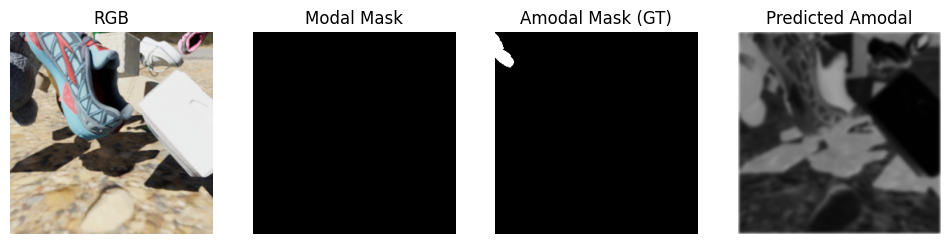

In [120]:
rgb_image, modal_mask, amodal_mask = next(iter(task_1_1_dataloader))
task_1_1_model.eval()
with torch.no_grad():
    input = torch.cat([rgb_image, modal_mask], dim=1)
    pred_amodal = task_1_1_model(input)

plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.imshow(rgb_image[0].permute(1,2,0).numpy())
plt.title("RGB")
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(modal_mask[0,0].numpy(), cmap='gray')
plt.title("Modal Mask")
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(amodal_mask[0,0].numpy(), cmap='gray')
plt.title("Amodal Mask (GT)")
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(pred_amodal[0,0].numpy(), cmap='gray')
plt.title("Predicted Amodal")
plt.axis('off')
plt.show()

---
### Task 1.2

In [121]:
def make_dataset12(videos_dir: str, 
                          inds: list[int] or None = None, 
                          random_seed: int = 42) -> tuple[torch.tensor, torch.tensor, list[dict]]: 
    """ 
    Loads one frame for every object viewed from every camera angle in every video in videos_dir and 
    returns the modal masks and amodal masks in tensor form.

    Parameters:
        - videos_dir: a directory where each sub-directory contains a video from Movi-MC-AC
        - inds: a list of the same length as the number of videos telling which frame of each video to load into the dataset
        - random_seed: an integer to set the random seed. Only necessary if inds is None.

    Returns: 
        - a tensor of modal masks
        - a tensor of amodal masks
        - a list of ALL images from ALL videos. TODO: abstract this into a separate function
        - TODO: also return a tensor of RGB images
    """

    # Save the RNG state to restore it after we're done
    prev_state = random.getstate()
    random.seed(random_seed)

    # If user does not specify, take one random frame from each video
    if inds is None: 
        inds = [random.randint(0, num_frames - 1) for i in range(num_vids)]
    random.setstate(prev_state)

    # Load a dictionary storing each video file
    videos_dir = Path(videos_dir)
    video_dicts = [get_sample_dict(Path(sample_dir)) for sample_dir in videos_dir.iterdir()]

    num_vids = len(video_dicts)

    # Count number of objects in each video
    num_obj_list = [None] * num_vids 
    for i in range(num_vids):
        num_obj_list[i] = sum([s.startswith('obj') for s in video_dicts[i]['camera_0000'].keys()])

    num_obj = sum(num_obj_list)
    
    # Every video in Movi-MC-AC has 24 frames and 6 camera angles
    num_cams = 6 
    num_frames = 24 

    # Sample size
    dataset_len = num_vids * num_cams * num_obj
    
    
    rgb_tensor = torch.empty((dataset_len, 3, 256, 256))
    modal_tensor = torch.empty((dataset_len, 256, 256))
    amodal_tensor = torch.empty((dataset_len, 256, 256))
    amodal_content_tensor = torch.empty((dataset_len, 3, 256, 256))

    l = 0 # iterates through l = 0, ..., dataset_len - 1
    for i in range(num_vids): # for each video
        video_dict = video_dicts[i]
        cur_num_obj = num_obj_list[i]
        for j in range(num_cams): # for each camera angle
            cam_dict = video_dict[f'camera_{j:04d}']
            modal_masks = Image.open(cam_dict['scene']['segmentation'][inds[i]]) # load the modal masks
            rgb_image = Image.open(cam_dict['scene']['rgba'][inds[i]]).convert('RGB')
            rgb_mask = image_to_tensor(rgb_image)


            for k in range(cur_num_obj): # for each object
                amodal_mask = Image.open(cam_dict[f'obj_{k+1:04d}']['segmentation'][inds[i]]) # load the amodal mask
                amodal_content = Image.open(cam_dict[f'obj_{k+1:04d}']['rgba'][inds[i]]).convert('RGB')
                modal_mask = (torch.tensor(np.array(modal_masks)) == (k + 1)).float() # extract the modal mask of a single object
                amodal_mask = image_to_tensor(amodal_mask)
                amodal_content = image_to_tensor(amodal_content)

                modal_tensor[l,:,:] = modal_mask 
                amodal_tensor[l,:,:] = amodal_mask
                rgb_tensor[l,:,:,:] = rgb_mask
                amodal_content_tensor[l,:,:,:] = amodal_content
                l += 1
    
    return rgb_tensor, modal_tensor, amodal_tensor, amodal_content_tensor, video_dicts


### Model

In [122]:
class Task_1_2_Dataset(Dataset):
    def __init__(self, rgb_tensor, modal_tensor, amodal_tensor, amodal_content_tensor):
        self.rgb_tensor = rgb_tensor
        self.modal_tensor = modal_tensor
        self.amodal_tensor = amodal_tensor
        self.amodal_content_tensor = amodal_content_tensor

    def __len__(self):
        return self.rgb_tensor.shape[0]
    
    def __getitem__(self, index):
        return self.rgb_tensor[index], self.modal_tensor[index], self.amodal_tensor[index], self.amodal_content_tensor[index]

In [123]:
class Task_1_2_Model(nn.Module):

    def __init__(self):
        super(Task_1_2_Model, self).__init__()
        # Define multiple Conv2D layers with 'same' padding
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)

        x = self.decoder(x)

        return x

In [124]:
task_1_2_model = Task_1_2_Model()
task_1_2_model

Task_1_2_Model(
  (conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

### Train

In [125]:
def train_task_1_2(model, dataloader, num_epochs=3, learning_rate=3e-5):
    loss_fn = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    

    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        for rgb_frame, modal_mask, amodal_mask, amodal_content in dataloader:
            optimizer.zero_grad()

            model_input = torch.cat([rgb_frame, amodal_mask.unsqueeze(1)], dim=1)


            amodal_content_pred = model(model_input)

            loss = loss_fn(amodal_content_pred, amodal_content)

            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        avg_loss = sum(epoch_losses) / len(epoch_losses)
        print(f'epoch: {epoch+1}, loss={avg_loss}')

    return avg_loss



        



In [126]:
rgb_tensor, modal_tensor, amodal_tensor, amodal_content_tensor, video_dicts = make_dataset12(DIR_DATA, [0])

In [127]:
train_dataset_1_2 = Task_1_2_Dataset(rgb_tensor, modal_tensor, amodal_tensor, amodal_content_tensor)

In [128]:
task_1_2_dataloader = DataLoader(train_dataset_1_2, batch_size=4, shuffle=True)

In [129]:
train_losses = train_task_1_2(task_1_2_model, task_1_2_dataloader, num_epochs=3, learning_rate=3e-4)

epoch: 1, loss=0.010671165093362075
epoch: 2, loss=0.005157494742888957
epoch: 3, loss=0.0021007712348364294


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.047192454..1.0463448].


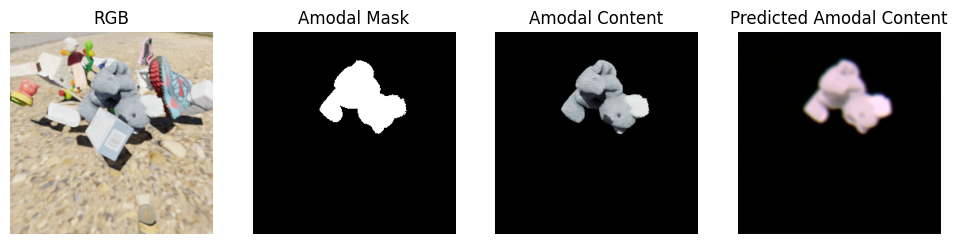

In [131]:
rgb_image, modal_mask, amodal_mask, amodal_content = next(iter(task_1_2_dataloader))
task_1_1_model.eval()
with torch.no_grad():
    input = torch.cat([rgb_image, amodal_mask.unsqueeze(1)], dim=1)
    pred_amodal_content = task_1_2_model(input)

plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.imshow(rgb_image[0].permute(1,2,0).numpy())
plt.title("RGB")
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(amodal_mask[0].numpy(), cmap='gray')
plt.title("Amodal Mask")
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(amodal_content[0].permute(1,2,0).numpy(), cmap='gray')
plt.title("Amodal Content")
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(pred_amodal_content[0].permute(1,2,0).numpy(), cmap='gray')
plt.title("Predicted Amodal Content")
plt.axis('off')
plt.show()